In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn import metrics

**Importing Data**

In [2]:
data= pd.read_csv("flights.csv",low_memory=False)

**Selecting subset of data**


In [3]:
df= data.iloc[:100000]

In [4]:
df.shape

(100000, 31)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 31 columns):
YEAR                   100000 non-null int64
MONTH                  100000 non-null int64
DAY                    100000 non-null int64
DAY_OF_WEEK            100000 non-null int64
AIRLINE                100000 non-null object
FLIGHT_NUMBER          100000 non-null int64
TAIL_NUMBER            99833 non-null object
ORIGIN_AIRPORT         100000 non-null object
DESTINATION_AIRPORT    100000 non-null object
SCHEDULED_DEPARTURE    100000 non-null int64
DEPARTURE_TIME         97702 non-null float64
DEPARTURE_DELAY        97702 non-null float64
TAXI_OUT               97629 non-null float64
WHEELS_OFF             97629 non-null float64
SCHEDULED_TIME         100000 non-null float64
ELAPSED_TIME           97387 non-null float64
AIR_TIME               97387 non-null float64
DISTANCE               100000 non-null int64
WHEELS_ON              97560 non-null float64
TAXI_IN                

In [6]:
df.head(2)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


#### Number of Flights got diverted

In [7]:
df['DIVERTED'].value_counts()

0    99776
1      224
Name: DIVERTED, dtype: int64

**Correlation Matrix**

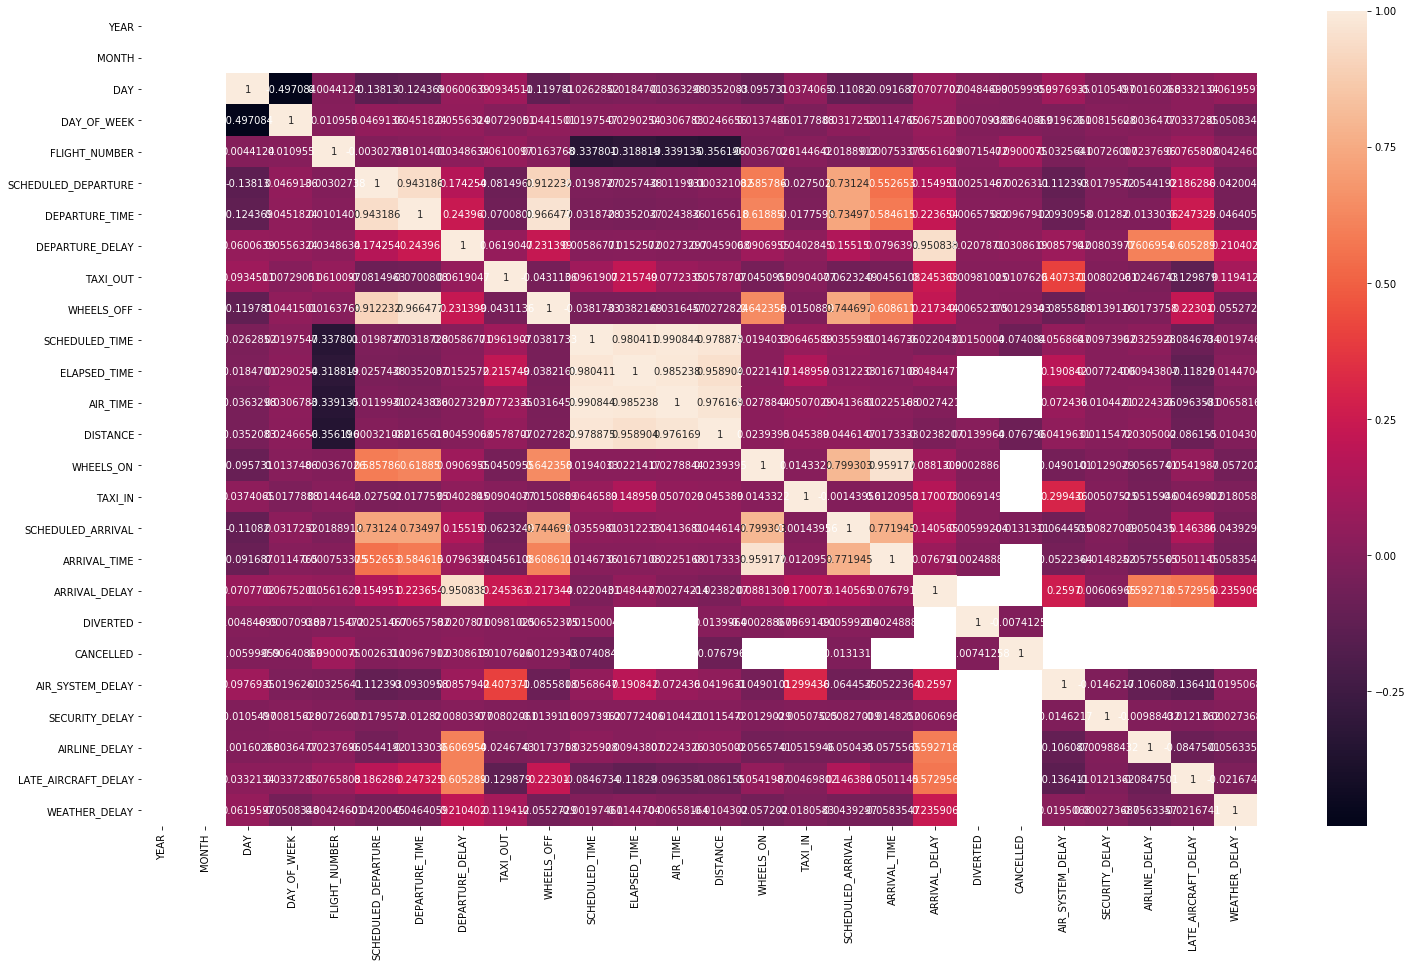

In [8]:
plt.figure(figsize = (25,15))
sns.heatmap(df.corr(), annot=True,fmt='g')
plt.show() 

In [9]:
df[df.columns[1:]].corr()['ARRIVAL_DELAY'][:].sort_values(ascending=False)

ARRIVAL_DELAY          1.000000
DEPARTURE_DELAY        0.950838
AIRLINE_DELAY          0.592718
LATE_AIRCRAFT_DELAY    0.572956
AIR_SYSTEM_DELAY       0.259700
TAXI_OUT               0.245363
WEATHER_DELAY          0.235906
DEPARTURE_TIME         0.223654
WHEELS_OFF             0.217344
TAXI_IN                0.170073
SCHEDULED_DEPARTURE    0.154951
SCHEDULED_ARRIVAL      0.140565
WHEELS_ON              0.088131
ARRIVAL_TIME           0.076791
DAY                    0.070770
DAY_OF_WEEK            0.067520
FLIGHT_NUMBER          0.056163
ELAPSED_TIME           0.048448
SECURITY_DELAY         0.006070
AIR_TIME              -0.002742
SCHEDULED_TIME        -0.022043
DISTANCE              -0.023821
MONTH                       NaN
DIVERTED                    NaN
CANCELLED                   NaN
Name: ARRIVAL_DELAY, dtype: float64

**Dropping least correlated variables**

In [10]:
df.drop(['YEAR','FLIGHT_NUMBER','AIRLINE','DISTANCE','TAIL_NUMBER','TAXI_OUT','SCHEDULED_TIME','DEPARTURE_TIME','WHEELS_OFF','ELAPSED_TIME','AIR_TIME','WHEELS_ON','DAY_OF_WEEK','TAXI_IN','ARRIVAL_TIME','CANCELLATION_REASON'],inplace=True,axis=1)

C:\Users\Keerthi\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [11]:
df.columns

Index(['MONTH', 'DAY', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_DELAY', 'SCHEDULED_ARRIVAL',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'AIR_SYSTEM_DELAY',
       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
       'WEATHER_DELAY'],
      dtype='object')

**Handling Null Values**

In [12]:
df.isna().sum()

MONTH                      0
DAY                        0
ORIGIN_AIRPORT             0
DESTINATION_AIRPORT        0
SCHEDULED_DEPARTURE        0
DEPARTURE_DELAY         2298
SCHEDULED_ARRIVAL          0
ARRIVAL_DELAY           2613
DIVERTED                   0
CANCELLED                  0
AIR_SYSTEM_DELAY       65375
SECURITY_DELAY         65375
AIRLINE_DELAY          65375
LATE_AIRCRAFT_DELAY    65375
WEATHER_DELAY          65375
dtype: int64

**Replacing Null values with mean**


In [13]:
df=df.fillna(df.mean())

In [14]:
df.isna().sum()

MONTH                  0
DAY                    0
ORIGIN_AIRPORT         0
DESTINATION_AIRPORT    0
SCHEDULED_DEPARTURE    0
DEPARTURE_DELAY        0
SCHEDULED_ARRIVAL      0
ARRIVAL_DELAY          0
DIVERTED               0
CANCELLED              0
AIR_SYSTEM_DELAY       0
SECURITY_DELAY         0
AIRLINE_DELAY          0
LATE_AIRCRAFT_DELAY    0
WEATHER_DELAY          0
dtype: int64

Here we notice that there are no dependent variable yet which serves as our result wheather flight is delayed or not.
       So here  creating new feature called 'result' which takes the value 0 and 1.
 * 0 for the resulting flight is not delayed 
 * 1 for flight delayed.
       Imputing these values by using the condition if 'ARRIVAL_DELAY' is greater than 15 then imputing 1 else o.

In [15]:
result=[]
for row in df['ARRIVAL_DELAY']:
    if row > 15:
        result.append(1)
    else:
        result.append(0) 

In [16]:
df['result'] = result


In [17]:
df['result'].value_counts()

0    63779
1    36221
Name: result, dtype: int64

**Feature selection**

    Selecting only following columns for Model Building.
'MONTH', 'DAY', 'SCHEDULED_DEPARTURE', 'DEPARTURE_DELAY', 'SCHEDULED_ARRIVAL', 'DIVERTED', 'CANCELLED', 'AIR_SYSTEM_DELAY','SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY','WEATHER_DELAY', 'result'

In [18]:
df=df.drop(['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'ARRIVAL_DELAY'],axis=1)
df.columns

Index(['MONTH', 'DAY', 'SCHEDULED_DEPARTURE', 'DEPARTURE_DELAY',
       'SCHEDULED_ARRIVAL', 'DIVERTED', 'CANCELLED', 'AIR_SYSTEM_DELAY',
       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
       'WEATHER_DELAY', 'result'],
      dtype='object')

**Splitting data fro modelling**

In [19]:
df = df.values
X, y = df[:,:-1], df[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

#### Feature Scalling


In [20]:
scaled_features = StandardScaler().fit_transform(X_train, X_test)

#### Model: DecisionTreeClassifier

In [21]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)

In [22]:
pred = clf.predict_proba(X_test)

#### AUC score of Model

In [23]:
auc_score = roc_auc_score(y_test, pred[:,1])
auc_score

0.9981622762200015

In [24]:
print('AUC Score of Model is: {} %'.format(round(auc_score*100,2)))

AUC Score of Model is: 99.82 %


#### Confusion Matrix and Classification Report

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
result1 = confusion_matrix(y_test, pred[:,1])
print("Confusion Matrix:")
print(result1)
print('')
result2 = classification_report(y_test, pred[:,1])
print("Classification Report:",)
print (result2)
result3 = accuracy_score(y_test,pred[:,1])
print("Accuracy:",result3)

Confusion Matrix:
[[19119    21]
 [   28 10832]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     19140
         1.0       1.00      1.00      1.00     10860

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000

Accuracy: 0.9983666666666666


Text(0.5, 257.44, 'Predicted label')

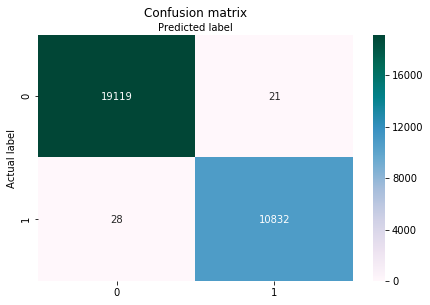

In [26]:
class_names=[0,1]
fig,ax=plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(result1), annot=True, cmap="PuBuGn" ,fmt='g')## visualized confusion matrix using heatmap
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

#### Receiver Operating Characteristic (ROC) curve of DecisionTreeClassifier

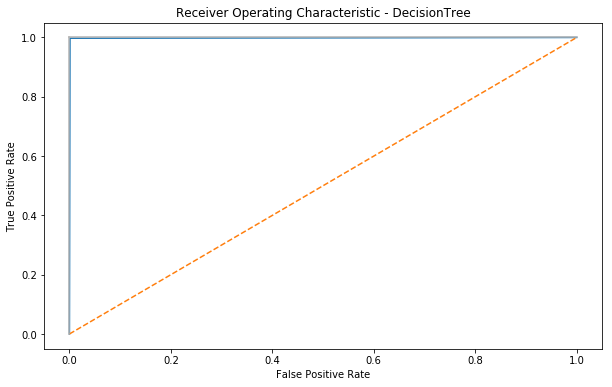

In [27]:
plt.subplots(1, figsize=(10,6))
plt.title('Receiver Operating Characteristic - DecisionTree')
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Accuracy, Precision, and Recall achived by model.

In [28]:
print("Accuracy Achieved:",round(metrics.accuracy_score(y_test, pred[:,1])*100,2),'%')
print(' ')
print("Precision Achieved:",round(metrics.precision_score(y_test, pred[:,1])*100,2),'%')
print(' ')
print("Recall Achieved:",round(metrics.recall_score(y_test, pred[:,1])*100,2),'%')

Accuracy Achieved: 99.84 %
 
Precision Achieved: 99.81 %
 
Recall Achieved: 99.74 %
